# Assessment of vancomycin vs. another antibiotic

In clinical practice, the pertinent question is often not "should I use vancomycin?", but rather "should I use vancomycin or this other antibiotic?". This notebook aims to quantify the risk of nephrotoxicity when using vancomycin over the other antibiotic.


## Definitions

* **drug on admission:** patient received medication order -12 to 12 hours upon admission to the ICU
* **baseline creatinine:** first creatinine value between -12 to 12 hours upon admission to the ICU
* **AKI:** following KDIGO guidelines using only creatinine, any instance of AKI between 2-7 days after their ICU admission.

KDIGO guidelines for AKI are: >= 50% change from baseline over 7 days, or absolute increase of 0.3 in creatinine over 48 hours.

## 0. Setup

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import psycopg2

from tqdm import tqdm_notebook as tqdm

# helper functions stored in local py file
import utils

# 1. Extract data and apply exclusions

For more detail on exclusions, see the main vancomycin analysis notebook.

In [2]:
# cohort with exclusions applied
co = pd.read_csv('data/cohort.csv.gz')

Below we summarize the initial population size and the exclusions resulting in the final population

In [3]:
# remove corrupt hospitals & admissions before 2005 before summarizing the cohort

# for some of the exclusions, we don't want to include them in the denominator
# mainly they are unrelated to actual patient case-mix
pre_exclude = ('exclude_corrupt_hospitals', 'exclude_before_2005')

for c in pre_exclude:
    co = co.loc[co[c]==0]

print('== EXCLUSIONS - TOTAL ==')
N = co.shape[0]
print(f'{N:6d} unique unit stays.')
for c in co.columns:
    if c in pre_exclude:
        continue

    if c.startswith('exclude_'):
        N = co[c].sum()
        mu = co[c].mean()*100.0
        print(f'  {N:6d} ({mu:4.1f}%) - {c}')
        
print('\n== EXCLUSIONS - SEQUENTIAL ==')
N = co.shape[0]
print(f'{N:7d} unique unit stays.')
idx = co['patientunitstayid'].notnull()
for c in co.columns:
    if c in pre_exclude:
        continue

    if c.startswith('exclude_'):
        # index patients removed by this exclusion
        idxRem = (co[c]==1)
        # calculate number of patients being removed, after applying prev excl
        N = (idx & idxRem).sum()
        mu = N/co.shape[0]*100.0
        idx = idx & (~idxRem)
        n_rem = idx.sum()
        
        print(f'- {N:5d} = {n_rem:6d} ({mu:4.1f}% removed) - {c}')
        
        
# create a cohort ID variable
co_id = set(co.loc[idx, 'patientunitstayid'])

== EXCLUSIONS - TOTAL ==
3089748 unique unit stays.
  438245 (14.2%) - exclude_sdu
  116797 ( 3.8%) - exclude_short_stay
  1833830 (59.4%) - exclude_non_ed_admit
  2115226 (68.5%) - exclude_secondary_stay
  1570462 (50.8%) - exclude_missing_apache
  484535 (15.7%) - exclude_no_med_interface
  111555 ( 3.6%) - exclude_dialysis_chronic
  299980 ( 9.7%) - exclude_dialysis_first_week
  513293 (16.6%) - exclude_cr_missing_baseline
  1192358 (38.6%) - exclude_cr_missing_followup

== EXCLUSIONS - SEQUENTIAL ==
3089748 unique unit stays.
- 438245 = 2651503 (14.2% removed) - exclude_sdu
- 80573 = 2570930 ( 2.6% removed) - exclude_short_stay
- 1409906 = 1161024 (45.6% removed) - exclude_non_ed_admit
- 255882 = 905142 ( 8.3% removed) - exclude_secondary_stay
- 280553 = 624589 ( 9.1% removed) - exclude_missing_apache
- 99260 = 525329 ( 3.2% removed) - exclude_no_med_interface
- 17496 = 507833 ( 0.6% removed) - exclude_dialysis_chronic
- 37922 = 469911 ( 1.2% removed) - exclude_dialysis_first_week


In [4]:
# covariates from APACHE table
dem = pd.read_csv('data/demographics.csv.gz')

# abx drug doses
va = pd.read_csv('data/vanco.csv.gz')
ce = pd.read_csv('data/cefepime.csv.gz')
zo = pd.read_csv('data/zosyn.csv.gz')
li = pd.read_csv('data/linezolid.csv.gz')
me = pd.read_csv('data/meropenem.csv.gz')
aki = pd.read_csv('data/aki.csv.gz')
# aki is either 48hr or 7day criteria
aki['aki'] = ((aki['aki_48h'] == 1) | (aki['aki_7d'] == 1)).astype(int)

# APACHE
apache = pd.read_csv('data/apache.csv.gz')

# convert apache predictions into numeric
apache['apache_prob'] = pd.to_numeric(apache['apache_prob'])

# sepsis/infection/organ failure
dx = pd.read_csv('data/sepsis_infection.csv.gz')

/home/alistairewj/miniconda3/envs/vanco-renal-toxicity/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning: Columns (14,15,16,17) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


## Merge data

The antibiotic administration data extracted above has all administrations from time 0.
Thus, three dataframes need to be extracted before we can merge data:

1. Extract vanco_adm and vanco_wk
2. Extract cefepime_adm and cefepime_wk
3. Extract zosyn_adm and zosyn_wk

In [5]:
v_df = utils.extract_adm_and_wk(va, 'vanco')
c_df = utils.extract_adm_and_wk(ce, 'cefepime')
z_df = utils.extract_adm_and_wk(zo, 'zosyn')
l_df = utils.extract_adm_and_wk(li, 'linezolid')
m_df = utils.extract_adm_and_wk(me, 'meropenem')

v_df.head()

,vanco_adm,vanco_wk
patientunitstayid,,
9,1,0
15,1,1
20,1,1
21,0,0
23,1,1


In [6]:
pd.crosstab(v_df['vanco_adm'], v_df['vanco_wk'])

vanco_wk,0,1
vanco_adm,,
0,82717,156471
1,191855,173867


We have two variables here: `vanco_adm` and `vanco_wk`.

* `vanco_adm`: did the patient receive vancomycin on ICU admission
* `vanco_wk`: did the patient receive vancomycin at some time >= 48 hours after ICU admission

We require both to be true to filter to patients who were administered vancomycin on ICU admission for at least 48 hours.

## Apply exclusions and create final dataframe

The `prepare_dataframe` function merges the data into a single dataframe, applying exclusions from `co` and subselecting certain variables.

In particular, this function will create a `vanco` column, which is equal to `(vanco_adm == 1) & (vanco_wk == 1)`.
Similarly it will create a `cefepime` and `zosyn` column

In [7]:
def summarize_abx_use(df):
    print('{} patients.'.format(df.shape[0]))

    print('Antibiotic use for 48 hours in the ICU:')
    for abx in ['vanco', 'cefepime', 'zosyn', 'linezolid', 'meropenem']:
        N = df[abx].sum()
        mu = N/df.shape[0]*100.0
        print(f'  {N:5d} ({mu:4.1f}%) - {abx}')


    print('\nConcurrent antibiotic use:')
    concurrent_abx = [
        ['vanco', 'cefepime'],
        ['vanco', 'zosyn'],
        ['vanco', 'meropenem']
    ]
    for abx1, abx2 in concurrent_abx:
        N = ((df[abx1] == 1) & (df[abx2] == 1)).sum()
        mu = N/df.shape[0]*100.0
        print(f'  {N:5d} ({mu:4.1f}%) - {abx1} & {abx2}')

In [8]:
df = utils.prepare_dataframe(co, dem, aki, apache, dx, drug_dfs=[v_df, c_df, z_df, l_df, m_df])
    
df.head()

,age,gender,ethnicity,weight_avg,height_cm,bmi,hospital_los_hours,hospital_admit_source,hospital_disch_location,hospital_mortality,...,cefepime,zosyn_adm,zosyn_wk,zosyn,linezolid_adm,linezolid_wk,linezolid,meropenem_adm,meropenem_wk,meropenem
patientunitstayid,,,,,,,,,,,,,,,,,,,,,
141139,50,Male,Caucasian,111.27,193.0,30.0,90.083333,Emergency Department,Home,0.0,...,0,0,0,0,0,0,0,0,0,0
141144,65,Female,Caucasian,102.71,167.6,37.0,474.183333,Emergency Department,SNF,0.0,...,0,0,0,0,0,0,0,0,0,0
141151,67,Male,Caucasian,86.05,172.5,29.0,72.583333,Emergency Department,Home,0.0,...,0,0,0,0,0,0,0,0,0,0
141156,90,Male,Caucasian,76.10,172.7,26.0,68.333333,Emergency Department,Home,0.0,...,0,0,0,0,0,0,0,0,0,0
141159,61,Male,African American,63.91,170.2,22.0,130.283333,Emergency Department,Home,0.0,...,0,0,0,0,0,0,0,0,0,0


In [9]:
# calculate proportion of various abx usage
summarize_abx_use(df)

262498 patients.
Antibiotic use for 48 hours in the ICU:
  30694 (11.7%) - vanco
   7119 ( 2.7%) - cefepime
  31377 (12.0%) - zosyn
    983 ( 0.4%) - linezolid
   2504 ( 1.0%) - meropenem

Concurrent antibiotic use:
   3208 ( 1.2%) - vanco & cefepime
  12718 ( 4.8%) - vanco & zosyn
   1108 ( 0.4%) - vanco & meropenem


# Demographics

In [10]:
from collections import OrderedDict
comparisons = OrderedDict()

idxCefepime = df['cefepime_adm'] == 1
idxZosyn = df['zosyn_adm'] == 1
idxVanco = df['vanco_adm'] == 1
idxMero = df['meropenem_adm'] == 1

idxVZ = idxVanco & idxZosyn & ~idxCefepime & ~idxMero
idxVC = idxVanco & ~idxZosyn & idxCefepime & ~idxMero
idxVM = idxVanco & ~idxZosyn & ~idxCefepime & idxMero

dd = df.copy()
dd['abx'] = 'v+z'
dd.loc[idxVC, 'abx'] = 'v+c'
dd.loc[idxVM, 'abx'] = 'v+m'
dd = dd.loc[idxVZ | idxVC | idxVM]

for c in ['aki_48h', 'aki_7d', 'aki', 'hospital_mortality']:
    dd[c] = dd[c] * 100
print(dd.shape)
dd.head()

(33097, 48)


,age,gender,ethnicity,weight_avg,height_cm,bmi,hospital_los_hours,hospital_admit_source,hospital_disch_location,hospital_mortality,...,zosyn_adm,zosyn_wk,zosyn,linezolid_adm,linezolid_wk,linezolid,meropenem_adm,meropenem_wk,meropenem,abx
patientunitstayid,,,,,,,,,,,,,,,,,,,,,
141187,42,Male,NaN,88.00,165.1,32.0,194.483333,Emergency Department,Home,0.0,...,0,0,0,0,0,0,0,0,0,v+c
141241,36,Female,Caucasian,101.45,160.0,40.0,358.300000,NaN,OtherExternal,0.0,...,1,0,0,0,1,0,0,0,0,v+z
141332,56,Male,Caucasian,93.90,177.8,30.0,163.316667,NaN,NursingHome,0.0,...,0,0,0,0,0,0,0,0,0,v+c
141356,87,Male,Caucasian,78.86,180.3,24.0,250.716667,Emergency Department,Home,0.0,...,1,0,0,0,0,0,0,0,0,v+z
141549,73,Male,Caucasian,93.23,167.6,33.0,129.766667,NaN,SNF,0.0,...,1,1,1,0,0,0,0,0,0,v+z


In [11]:
dd.columns

Index(['age', 'gender', 'ethnicity', 'weight_avg', 'height_cm', 'bmi',
       'hospital_los_hours', 'hospital_admit_source',
       'hospital_disch_location', 'hospital_mortality', 'icu_los_hours',
       'unitdischargeoffset', 'apachescore', 'region', 'teachingstatus',
       'numbedscategory', 'apache_group', 'bmi_group', 'creatinine_aki',
       'chartoffset_aki', 'creatinine_baseline', 'aki_48h', 'aki_7d', 'aki',
       'apache_prob', 'immunocompromised', 'sepsis_explicit', 'infection',
       'organfailure', 'infection_skin_soft_tissue', 'sepsis', 'egfr',
       'vanco_adm', 'vanco_wk', 'vanco', 'cefepime_adm', 'cefepime_wk',
       'cefepime', 'zosyn_adm', 'zosyn_wk', 'zosyn', 'linezolid_adm',
       'linezolid_wk', 'linezolid', 'meropenem_adm', 'meropenem_wk',
       'meropenem', 'abx'],
      dtype='object')

In [12]:
from tableone import TableOne

cols = [
    'age', 'gender', 'ethnicity', 'bmi', 'apachescore',
    'egfr',
    'aki_48h', 'aki_7d', 'aki',
    'immunocompromised',
    'abx',
    'hospital_los_hours',
    'hospital_disch_location',
    'hospital_mortality',
    'region', 'teachingstatus', 'numbedscategory'
]
categorical = ['ethnicity', 'gender', 'immunocompromised', 'abx', 'hospital_disch_location',
              'region', 'teachingstatus', 'numbedscategory']
t1 = TableOne(dd, columns=cols, categorical=categorical)
t1

Missing        Overall
n                                                         33097
age                                            0    65.6 (16.4)
gender                  Female                 0   15137 (45.7)
                        Male                       17959 (54.3)
                        Other                           1 (0.0)
ethnicity               African American     201    3661 (11.1)
                        Asian                         442 (1.3)
                        Caucasian                  25417 (77.3)
                        Hispanic                     1807 (5.5)
                        Native American               282 (0.9)
                        Other/Unknown                1287 (3.9)
bmi                                          709     28.6 (9.2)
apachescore                                    0    69.0 (25.8)
egfr                                           0    72.4 (58.2)
aki_48h                                        0    25.5 (43.6)
aki_7d                                         0    10.4 (30.6)
aki                                            0    27.5 (44.7)
immunocompromised       no                     0   31256 (94.4)
                        yes                          1841 (5.6)
abx                     v+c                    0    5978 (18.1)
                        v+m                          1719 (5.2)
                        v+z                        25400 (76.7)
hospital_los_hours                             0  240.0 (209.7)
hospital_disch_location Death                  0    4328 (13.1)
                        Home                       14650 (44.3)
                        NursingHome                  1653 (5.0)
                        Other                         835 (2.5)
                        OtherExternal                2439 (7.4)
                        OtherHospital                1533 (4.6)
                        SNF                         7659 (23.1)
hospital_mortality                             0    13.1 (33.7)
region                  Midwest             2118   13001 (42.0)
                        Northeast                   4677 (15.1)
                        South                       9000 (29.1)
                        West                        4301 (13.9)
teachingstatus          False               1755   20802 (66.4)
                        True                       10540 (33.6)
numbedscategory         100-249             2608    8171 (26.8)
                        250-500                     6698 (22.0)
                        <100                         1017 (3.3)
                        >500                       14603 (47.9)
[1] Warning, Hartigan's Dip Test reports possible multimodal distributions for: age, bmi, apachescore, aki_48h, aki_7d, aki, hospital_los_hours, hospital_mortality.
[2] Warning, Tukey test indicates far outliers in: bmi, apachescore, egfr, aki_7d, hospital_los_hours, hospital_mortality.
[3] Warning, test for normality reports non-normal distributions for: age, bmi, apachescore, egfr, aki_48h, aki_7d, aki, hospital_los_hours, hospital_mortality.

In [13]:
t1 = TableOne(
    dd, columns=cols,
    categorical=categorical,
    groupby='abx'
)
t1

Grouped by abx                                             
                                                Missing            v+c            v+m            v+z
n                                                                 5978           1719          25400
age                                                   0    66.1 (15.8)    64.4 (16.3)    65.5 (16.5)
gender                  Female                        0    2861 (47.9)     874 (50.8)   11402 (44.9)
                        Male                               3117 (52.1)     844 (49.1)   13998 (55.1)
                        Other                                                 1 (0.1)               
ethnicity               African American            201     624 (10.5)     245 (14.5)    2792 (11.1)
                        Asian                                 63 (1.1)       31 (1.8)      348 (1.4)
                        Caucasian                          4835 (81.2)    1251 (73.8)   19331 (76.6)
                        Hispanic                             210 (3.5)       63 (3.7)     1534 (6.1)
                        Native American                       31 (0.5)        5 (0.3)      246 (1.0)
                        Other/Unknown                        192 (3.2)      100 (5.9)      995 (3.9)
bmi                                                 709     29.0 (9.3)     28.8 (9.8)     28.5 (9.2)
apachescore                                           0    68.8 (24.8)    70.2 (25.7)    68.9 (26.0)
egfr                                                  0    73.6 (62.9)    71.7 (62.7)    72.1 (56.7)
aki_48h                                               0    23.3 (42.3)    21.3 (41.0)    26.3 (44.0)
aki_7d                                                0     8.4 (27.8)     7.2 (25.9)    11.1 (31.4)
aki                                                   0    24.9 (43.2)    22.4 (41.7)    28.5 (45.1)
immunocompromised       no                            0    5400 (90.3)    1604 (93.3)   24252 (95.5)
                        yes                                  578 (9.7)      115 (6.7)     1148 (4.5)
abx                     v+c                           0   5978 (100.0)                              
                        v+m                                              1719 (100.0)               
                        v+z                                                            25400 (100.0)
hospital_los_hours                                    0  244.7 (247.7)  245.4 (209.4)  238.5 (199.7)
hospital_disch_location Death                         0     770 (12.9)     212 (12.3)    3346 (13.2)
                        Home                               2576 (43.1)     752 (43.7)   11322 (44.6)
                        NursingHome                          333 (5.6)       81 (4.7)     1239 (4.9)
                        Other                                135 (2.3)       49 (2.9)      651 (2.6)
                        OtherExternal                        440 (7.4)      116 (6.7)     1883 (7.4)
                        OtherHospital                        251 (4.2)      101 (5.9)     1181 (4.6)
                        SNF                                1473 (24.6)     408 (23.7)    5778 (22.7)
hospital_mortality                                    0    12.9 (33.5)    12.3 (32.9)    13.2 (33.8)
region                  Midwest                    2118    2203 (38.3)     606 (37.4)   10192 (43.2)
                        Northeast                          1264 (22.0)       88 (5.4)    3325 (14.1)
                        South                              1491 (25.9)     628 (38.8)    6881 (29.1)
                        West                                795 (13.8)     298 (18.4)    3208 (13.6)
teachingstatus          False                      1755    3743 (64.7)    1106 (67.6)   15953 (66.7)
                        True                               2039 (35.3)     529 (32.4)    7972 (33.3)
numbedscategory         100-249                    2608    1144 (20.4)     543 (34.2)    6484 (27.8)
 

# Time to AKI

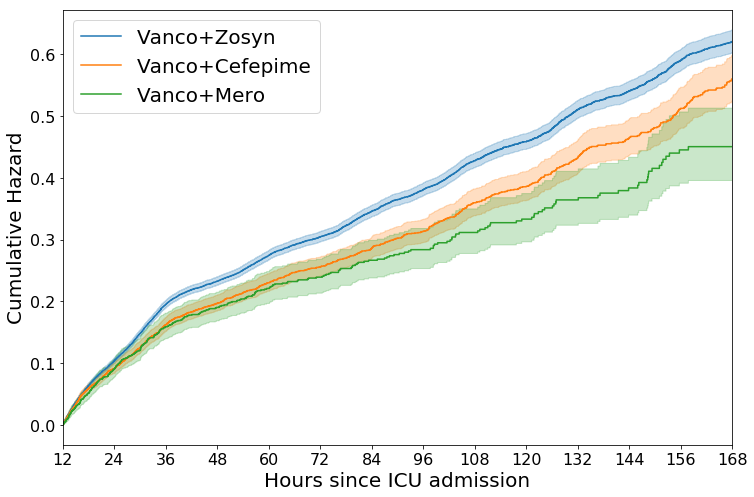

In [15]:
from lifelines import NelsonAalenFitter

idxCefepime = df['cefepime_adm'] == 1
idxZosyn = df['zosyn_adm'] == 1
idxVanco = df['vanco_adm'] == 1
idxMero = df['meropenem_adm'] == 1

idxVZ = idxVanco & idxZosyn & ~idxCefepime & ~idxMero
idxVC = idxVanco & ~idxZosyn & idxCefepime & ~idxMero
idxVM = idxVanco & ~idxZosyn & ~idxCefepime & idxMero

def plot_hazard_line(idx, label):
    tm_to_aki = df.loc[idx, ['aki', 'chartoffset_aki', 'unitdischargeoffset']].copy()

    tm_to_aki['time'] = tm_to_aki['chartoffset_aki']
    idx = tm_to_aki['aki'] == 0
    tm_to_aki.loc[idx, 'time'] = tm_to_aki.loc[idx, 'unitdischargeoffset']

    # convert time from minutes to hours
    tm_to_aki['time'] = tm_to_aki['time'] / 60.0

    naf = NelsonAalenFitter()
    naf.fit(tm_to_aki['time'].values, event_observed=tm_to_aki['aki'].values)
    naf.plot(label=label)

# plot a line for each group
plt.figure(figsize=[12, 8])
plot_hazard_line(idxVZ, 'Vanco+Zosyn')
plot_hazard_line(idxVC, 'Vanco+Cefepime')
plot_hazard_line(idxVM, 'Vanco+Mero')

plt.xlim([12, 7*24])
plt.xticks(range(12, 7*24+1, 12), fontsize=16)
plt.yticks(fontsize=16)
plt.ylabel('Cumulative Hazard', fontsize=20)
plt.xlabel('Hours since ICU admission', fontsize=20)
plt.legend(fontsize=20)
plt.show()

# Analyses

- Primary: drug on adm
- Secondary: drug on adm *for at least 48 hr* (adm + "wk")


We will compare three groups of patients: 

* vancomycin and zosyn
* vancomycin and cefepime
* vancomycin and meropenem

In order to make this comparison clear, we'll define all the groups upfront, then later run the comparison.

In [16]:
from collections import OrderedDict
comparisons = OrderedDict()

idxCefepime = df['cefepime_adm'] == 1
idxZosyn = df['zosyn_adm'] == 1
idxVanco = df['vanco_adm'] == 1
idxMero = df['meropenem_adm'] == 1

idxVZ = idxVanco & idxZosyn & ~idxCefepime & ~idxMero
idxVC = idxVanco & ~idxZosyn & idxCefepime & ~idxMero
idxVM = idxVanco & ~idxZosyn & ~idxCefepime & idxMero

# Vanco + Zosyn vs Vanco + Cefepime
comparisons['v+z vs. v+c'] = {
    'exposure': df[idxVZ].copy(),
    'control': df[idxVC].copy(),
    'covariates': [
        'age', 'apache_prob', 'immunocompromised', 'egfr'
    ],
    'seed': 1000
}

# Vanco + Zosyn vs Vanco + Meropenem
comparisons['v+z vs. v+m'] = {
    'exposure': df[idxVZ].copy(),
    'control': df[idxVM].copy(),
    'covariates': [
        'age', 'apache_prob', 'immunocompromised', 'egfr'
    ],
    'seed': 1001
}

# repeat where we require exposure to be for at least 48 hours
idxCefepime_48hr = df['cefepime'] == 1
idxZosyn_48hr = df['zosyn'] == 1
idxVanco_48hr = df['vanco'] == 1
idxMero_48hr = df['meropenem'] == 1

idxVZ_48hr = idxVanco_48hr & idxZosyn_48hr & ~idxCefepime_48hr & ~idxMero_48hr
idxVC_48hr = idxVanco_48hr & ~idxZosyn_48hr & idxCefepime_48hr & ~idxMero_48hr
idxVM_48hr = idxVanco_48hr & ~idxZosyn_48hr & ~idxCefepime_48hr & idxMero_48hr


# Vanco + Zosyn vs Vanco + Cefepime
comparisons['v+z vs. v+c, 48hr'] = {
    'exposure': df[idxVZ_48hr].copy(),
    'control': df[idxVC_48hr].copy(),
    'covariates': [
        'age', 'apache_prob', 'immunocompromised', 'egfr'
    ],
    'seed': 1002
}

# Vanco + Zosyn vs Vanco + Meropenem
comparisons['v+z vs. v+m, 48hr'] = {
    'exposure': df[idxVZ_48hr].copy(),
    'control': df[idxVM_48hr].copy(),
    'covariates': [
        'age', 'apache_prob', 'immunocompromised', 'egfr'
    ],
    'seed': 1003
}

## Propensity score comparison

With the dataset defined, we can run the propensity score modeling followed by caliper matching to create two groups matched on the confounders.

In [17]:
for c_name, comparison in comparisons.items():
    print(f'{"="*5}{c_name}{"="*5}')
    # number of people in the groups
    exposure, control = comparison['exposure'], comparison['control']
    N = exposure.shape[0] + control.shape[0]
    print(f'Exposure: {exposure.shape[0]:5d} ({exposure.shape[0]/N*100.0:4.1f}%)')
    print(f'Control: {control.shape[0]:5d} ({control.shape[0]/N*100.0:4.1f}%)')
        
    m = utils.propensity_match(**comparison)

    # calculate a contingency table for each "strata"
    # here the strata are a match between a single patient in the minority group
    # and 1 or more patients in the majority group
    cm = utils.get_contingency_tables(m, outcome_var='aki')

    # CMH tests for the significance of the odds ratio between matched pairs
    pval, R, ci = utils.cmh_test(cm, alpha=0.05)
    pval_str = f'= {pval:1.3f}' if pval > 0.001 else '< 0.001'

    print('Result of propensity score followed by matching:')
    print(f'p {pval_str}.\nOdds ratio: {R:3.2f} [{ci[0]:3.2f} - {ci[1]:3.2f}].')

Column ethnicity missing 154 observations in exposure dataframe.
Column ethnicity missing 23 observations in control dataframe.
Column weight_avg missing 168 observations in exposure dataframe.
Column weight_avg missing 28 observations in control dataframe.
Column height_cm missing 499 observations in exposure dataframe.
Column height_cm missing 86 observations in control dataframe.
Column bmi missing 588 observations in exposure dataframe.
Column bmi missing 106 observations in control dataframe.
Column hospital_admit_source missing 5806 observations in exposure dataframe.
Column hospital_admit_source missing 1364 observations in control dataframe.
Column region missing 1794 observations in exposure dataframe.
Column region missing 225 observations in control dataframe.
Column teachingstatus missing 1475 observations in exposure dataframe.
Column teachingstatus missing 196 observations in control dataframe.
Column numbedscategory missing 2115 observations in exposure dataframe.
Column

=====v+z vs. v+c=====
Exposure: 25400 (80.9%)
Control:  5978 (19.1%)
Formula:
status ~ age+apache_prob+immunocompromised+egfr
n majority: 25400
n minority: 5978
Fitting 1 (Unbalanced) Model...

Accuracy 80.95


/home/alistairewj/miniconda3/envs/vanco-renal-toxicity/lib/python3.7/site-packages/pymatch/Matcher.py:199: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.matched_data['match_id'] = match_ids
/home/alistairewj/miniconda3/envs/vanco-renal-toxicity/lib/python3.7/site-packages/pymatch/Matcher.py:200: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.matched_data['record_id'] = self.matched_data.index
Column ethnicity missing 154 observations in exposure dataframe.
Column ethnicity missing 24 observations in control dataframe.
Column weight

Result of propensity score followed by matching:
p < 0.001.
Odds ratio: 1.20 [1.12 - 1.29].
=====v+z vs. v+m=====
Exposure: 25400 (93.7%)
Control:  1719 ( 6.3%)
Formula:
status ~ age+apache_prob+immunocompromised+egfr
n majority: 25400
n minority: 1719
Fitting 1 (Unbalanced) Model...

Accuracy 93.66


Column ethnicity missing 88 observations in exposure dataframe.
Column ethnicity missing 12 observations in control dataframe.
Column weight_avg missing 75 observations in exposure dataframe.
Column weight_avg missing 17 observations in control dataframe.
Column height_cm missing 221 observations in exposure dataframe.
Column height_cm missing 49 observations in control dataframe.
Column bmi missing 263 observations in exposure dataframe.
Column bmi missing 61 observations in control dataframe.
Column hospital_admit_source missing 2891 observations in exposure dataframe.
Column hospital_admit_source missing 684 observations in control dataframe.
Column region missing 1055 observations in exposure dataframe.
Column region missing 122 observations in control dataframe.
Column teachingstatus missing 835 observations in exposure dataframe.
Column teachingstatus missing 107 observations in control dataframe.
Column numbedscategory missing 1188 observations in exposure dataframe.
Column numb

Result of propensity score followed by matching:
p < 0.001.
Odds ratio: 1.38 [1.22 - 1.55].
=====v+z vs. v+c, 48hr=====
Exposure: 12607 (80.2%)
Control:  3116 (19.8%)
Formula:
status ~ age+apache_prob+immunocompromised+egfr
n majority: 12607
n minority: 3116
Fitting 1 (Unbalanced) Model...

Accuracy 80.18


Column ethnicity missing 88 observations in exposure dataframe.
Column ethnicity missing 16 observations in control dataframe.
Column weight_avg missing 75 observations in exposure dataframe.
Column weight_avg missing 4 observations in control dataframe.
Column height_cm missing 221 observations in exposure dataframe.
Column height_cm missing 7 observations in control dataframe.
Column bmi missing 263 observations in exposure dataframe.
Column bmi missing 11 observations in control dataframe.
Column hospital_admit_source missing 2891 observations in exposure dataframe.
Column hospital_admit_source missing 290 observations in control dataframe.
Column region missing 1055 observations in exposure dataframe.
Column region missing 52 observations in control dataframe.
Column teachingstatus missing 835 observations in exposure dataframe.
Column teachingstatus missing 44 observations in control dataframe.
Column numbedscategory missing 1188 observations in exposure dataframe.
Column numbedsc

Result of propensity score followed by matching:
p < 0.001.
Odds ratio: 1.34 [1.21 - 1.49].
=====v+z vs. v+m, 48hr=====
Exposure: 12607 (92.1%)
Control:  1077 ( 7.9%)
Formula:
status ~ age+apache_prob+immunocompromised+egfr
n majority: 12607
n minority: 1077
Fitting 1 (Unbalanced) Model...

Accuracy 92.13
Result of propensity score followed by matching:
p < 0.001.
Odds ratio: 1.64 [1.40 - 1.92].


## Details

Column ethnicity missing 154 observations in exposure dataframe.
Column ethnicity missing 24 observations in control dataframe.
Column weight_avg missing 168 observations in exposure dataframe.
Column weight_avg missing 3 observations in control dataframe.
Column height_cm missing 499 observations in exposure dataframe.
Column height_cm missing 12 observations in control dataframe.
Column bmi missing 588 observations in exposure dataframe.
Column bmi missing 15 observations in control dataframe.
Column hospital_admit_source missing 5806 observations in exposure dataframe.
Column hospital_admit_source missing 390 observations in control dataframe.
Column region missing 1794 observations in exposure dataframe.
Column region missing 99 observations in control dataframe.
Column teachingstatus missing 1475 observations in exposure dataframe.
Column teachingstatus missing 84 observations in control dataframe.
Column numbedscategory missing 2115 observations in exposure dataframe.
Column numb

Formula:
status ~ age+apache_prob+immunocompromised+egfr
n majority: 25400
n minority: 1719
Fitting Models on Balanced Samples: 1\100

/home/alistairewj/miniconda3/envs/vanco-renal-toxicity/lib/python3.7/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)
/home/alistairewj/miniconda3/envs/vanco-renal-toxicity/lib/python3.7/site-packages/pymatch/Matcher.py:103: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  uf.drop_static_cols(df[df[self.yvar] == 0], yvar=self.yvar)])


Fitting Models on Balanced Samples: 100\100
Average Accuracy: 52.21%


,var,before,after
0,immunocompromised,0.000046,0.73346


,var,ks_before,ks_after,grouped_chisqr_before,grouped_chisqr_after,std_median_diff_before,std_median_diff_after,std_mean_diff_before,std_mean_diff_after
0,age,0.002,0.002,0.004,0.007,0.060542,0.000000,0.067103,-0.002007
1,apache_prob,0.085,0.000,1.000,1.000,-0.046228,-0.036748,-0.018212,0.006420
2,egfr,0.207,0.020,0.302,0.000,0.024389,-0.005122,0.006483,0.006152


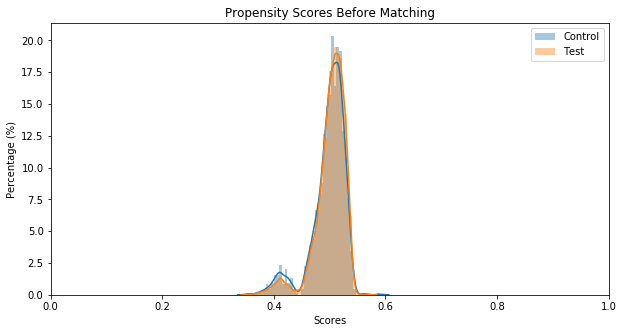

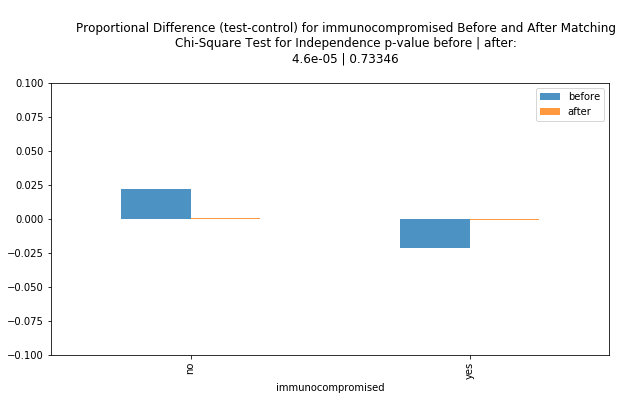

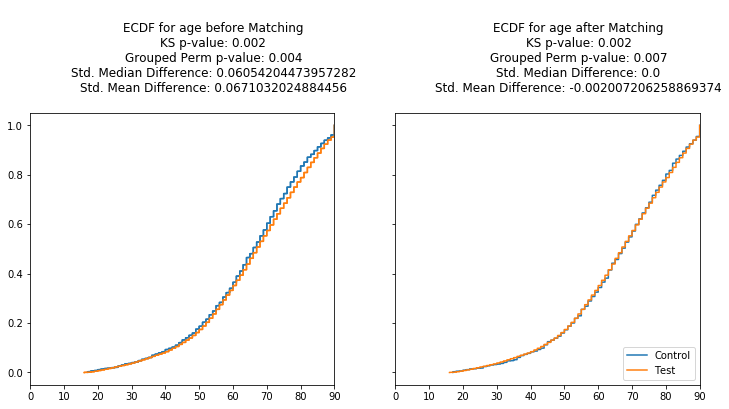

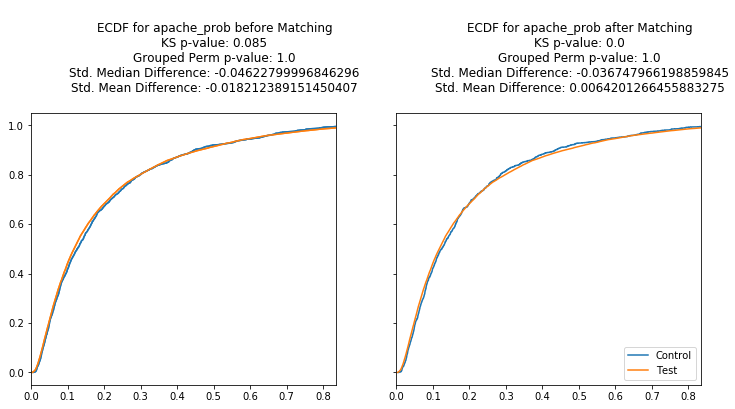

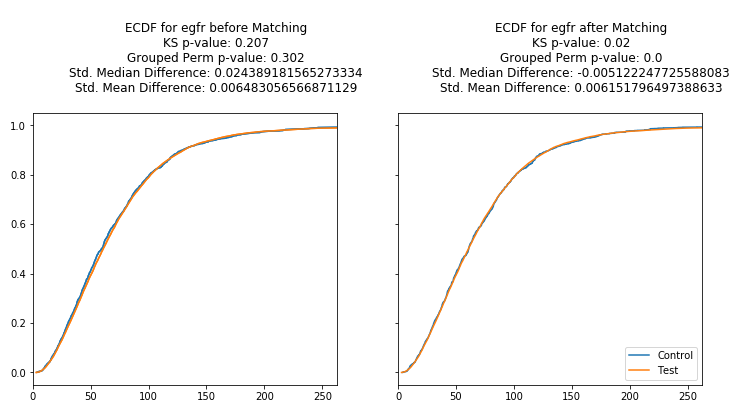

In [18]:
comparison = comparisons['v+z vs. v+m']
m = utils.propensity_match(**comparison, verbose=True, balance=True, n_models=100)

In [19]:
# calculate a contingency table for each "strata"
# here the strata are a match between a single patient in the minority group
# and 1 or more patients in the majority group
cm = utils.get_contingency_tables(m, outcome_var='aki')

# CMH tests for the significance of the odds ratio between matched pairs
pval, R, ci = utils.cmh_test(cm, alpha=0.05)
pval_str = f'= {pval:1.3f}' if pval > 0.001 else '< 0.001'

print('Result of propensity score followed by matching:')
print(f'p {pval_str}.\nOdds ratio: {R:3.2f} [{ci[0]:3.2f} - {ci[1]:3.2f}].')

Result of propensity score followed by matching:
p < 0.001.
Odds ratio: 1.41 [1.25 - 1.59].


## Subanalysis

## Subgroups of eGFR in other comparisons


We'd like to investigate whether subgrouping based off of eGFR at the time of ICU admission makes any difference.

In [20]:
def add_grouped_var(x: pd.Series, bins=[(0, 60)]):
    y = x.copy()
    bin_order = []
    for b in bins:
        idx = (x > b[0]) & (x <= b[1])
        bin_name = f'{b[0]} - {b[1]}'
        y.loc[idx] = bin_name
        bin_order.append(bin_name)


    idx = (x > b[1])
    bin_name = f'> {b[1]}'
    y.loc[idx] = bin_name
    bin_order.append(bin_name)
    
    return y, bin_order

seed_base = 1000
i = 0

egfr_ps, egfr_cm = {}, {}

for c_name, comparison in comparisons.items():
    exposure, control = comparison['exposure'].copy(), comparison['control'].copy()
    covariates = comparison['covariates']
    
    exposure['egfr_groups'], bin_order = add_grouped_var(exposure['egfr'])
    control['egfr_groups'], bin_order = add_grouped_var(control['egfr'])
    
    egfr_ps[c_name] = {}
    egfr_cm[c_name] = {}
    print(c_name)
    # calculate odds ratio in each group
    for b in bin_order:
        propensity_vars = {
            'exposure': exposure.loc[exposure['egfr_groups']==b],
            'control': control.loc[control['egfr_groups']==b],
            'covariates': covariates,
            'seed': seed_base+i
        }

        egfr_ps[c_name][b] = utils.propensity_match(**propensity_vars)

        # get CMs
        egfr_cm[c_name][b] = utils.get_contingency_tables(egfr_ps[c_name][b], outcome_var='aki')

        i+=1

Column ethnicity missing 76 observations in exposure dataframe.
Column ethnicity missing 11 observations in control dataframe.
Column weight_avg missing 78 observations in exposure dataframe.
Column weight_avg missing 9 observations in control dataframe.
Column height_cm missing 228 observations in exposure dataframe.
Column height_cm missing 49 observations in control dataframe.
Column bmi missing 272 observations in exposure dataframe.
Column bmi missing 54 observations in control dataframe.
Column hospital_admit_source missing 2810 observations in exposure dataframe.
Column hospital_admit_source missing 655 observations in control dataframe.
Column region missing 834 observations in exposure dataframe.
Column region missing 89 observations in control dataframe.
Column teachingstatus missing 677 observations in exposure dataframe.
Column teachingstatus missing 72 observations in control dataframe.
Column numbedscategory missing 1019 observations in exposure dataframe.
Column numbedsc

v+z vs. v+c


Column bmi_group missing 54 observations in control dataframe.


Formula:
status ~ age+apache_prob+immunocompromised+egfr
n majority: 12508
n minority: 2921
Fitting 1 (Unbalanced) Model...

Accuracy 81.07


Column ethnicity missing 78 observations in exposure dataframe.
Column ethnicity missing 12 observations in control dataframe.
Column weight_avg missing 90 observations in exposure dataframe.
Column weight_avg missing 19 observations in control dataframe.
Column height_cm missing 271 observations in exposure dataframe.
Column height_cm missing 37 observations in control dataframe.
Column bmi missing 316 observations in exposure dataframe.
Column bmi missing 52 observations in control dataframe.
Column hospital_admit_source missing 2996 observations in exposure dataframe.
Column hospital_admit_source missing 709 observations in control dataframe.
Column region missing 960 observations in exposure dataframe.
Column region missing 136 observations in control dataframe.
Column teachingstatus missing 798 observations in exposure dataframe.
Column teachingstatus missing 124 observations in control dataframe.
Column numbedscategory missing 1096 observations in exposure dataframe.
Column numbe

Formula:
status ~ age+apache_prob+immunocompromised+egfr
n majority: 12892
n minority: 3057
Fitting 1 (Unbalanced) Model...

Accuracy 80.83


Column ethnicity missing 76 observations in exposure dataframe.
Column ethnicity missing 12 observations in control dataframe.
Column weight_avg missing 78 observations in exposure dataframe.
Column height_cm missing 228 observations in exposure dataframe.
Column height_cm missing 9 observations in control dataframe.
Column bmi missing 272 observations in exposure dataframe.
Column bmi missing 9 observations in control dataframe.
Column hospital_admit_source missing 2810 observations in exposure dataframe.
Column hospital_admit_source missing 182 observations in control dataframe.
Column region missing 834 observations in exposure dataframe.
Column region missing 61 observations in control dataframe.
Column teachingstatus missing 677 observations in exposure dataframe.
Column teachingstatus missing 53 observations in control dataframe.
Column numbedscategory missing 1019 observations in exposure dataframe.
Column numbedscategory missing 72 observations in control dataframe.
Column bmi_

v+z vs. v+m
Formula:
status ~ age+apache_prob+immunocompromised+egfr
n majority: 12508
n minority: 866
Fitting 1 (Unbalanced) Model...

Accuracy 93.52


Column ethnicity missing 78 observations in exposure dataframe.
Column ethnicity missing 12 observations in control dataframe.
Column weight_avg missing 90 observations in exposure dataframe.
Column weight_avg missing 3 observations in control dataframe.
Column height_cm missing 271 observations in exposure dataframe.
Column height_cm missing 3 observations in control dataframe.
Column bmi missing 316 observations in exposure dataframe.
Column bmi missing 6 observations in control dataframe.
Column hospital_admit_source missing 2996 observations in exposure dataframe.
Column hospital_admit_source missing 208 observations in control dataframe.
Column region missing 960 observations in exposure dataframe.
Column region missing 38 observations in control dataframe.
Column teachingstatus missing 798 observations in exposure dataframe.
Column teachingstatus missing 31 observations in control dataframe.
Column numbedscategory missing 1096 observations in exposure dataframe.
Column numbedscat

Formula:
status ~ age+apache_prob+immunocompromised+egfr
n majority: 12892
n minority: 853
Fitting 1 (Unbalanced) Model...

Accuracy 93.79


Column ethnicity missing 43 observations in exposure dataframe.
Column ethnicity missing 7 observations in control dataframe.
Column weight_avg missing 37 observations in exposure dataframe.
Column weight_avg missing 5 observations in control dataframe.
Column height_cm missing 84 observations in exposure dataframe.
Column height_cm missing 24 observations in control dataframe.
Column bmi missing 106 observations in exposure dataframe.
Column bmi missing 27 observations in control dataframe.
Column hospital_admit_source missing 1315 observations in exposure dataframe.
Column hospital_admit_source missing 302 observations in control dataframe.
Column region missing 457 observations in exposure dataframe.
Column region missing 37 observations in control dataframe.
Column teachingstatus missing 350 observations in exposure dataframe.
Column teachingstatus missing 31 observations in control dataframe.
Column numbedscategory missing 531 observations in exposure dataframe.
Column numbedscate

v+z vs. v+c, 48hr
Formula:
status ~ age+apache_prob+immunocompromised+egfr
n majority: 5799
n minority: 1460
Fitting 1 (Unbalanced) Model...

Accuracy 79.89


Column ethnicity missing 45 observations in exposure dataframe.
Column ethnicity missing 5 observations in control dataframe.
Column weight_avg missing 38 observations in exposure dataframe.
Column weight_avg missing 12 observations in control dataframe.
Column height_cm missing 137 observations in exposure dataframe.
Column height_cm missing 25 observations in control dataframe.
Column bmi missing 157 observations in exposure dataframe.
Column bmi missing 34 observations in control dataframe.
Column hospital_admit_source missing 1576 observations in exposure dataframe.
Column hospital_admit_source missing 382 observations in control dataframe.
Column region missing 598 observations in exposure dataframe.
Column region missing 85 observations in control dataframe.
Column teachingstatus missing 485 observations in exposure dataframe.
Column teachingstatus missing 76 observations in control dataframe.
Column numbedscategory missing 657 observations in exposure dataframe.
Column numbedsca

Formula:
status ~ age+apache_prob+immunocompromised+egfr
n majority: 6808
n minority: 1656
Fitting 1 (Unbalanced) Model...

Accuracy 80.43


Column ethnicity missing 43 observations in exposure dataframe.
Column ethnicity missing 9 observations in control dataframe.
Column weight_avg missing 37 observations in exposure dataframe.
Column weight_avg missing 1 observations in control dataframe.
Column height_cm missing 84 observations in exposure dataframe.
Column height_cm missing 5 observations in control dataframe.
Column bmi missing 106 observations in exposure dataframe.
Column bmi missing 6 observations in control dataframe.
Column hospital_admit_source missing 1315 observations in exposure dataframe.
Column hospital_admit_source missing 123 observations in control dataframe.
Column region missing 457 observations in exposure dataframe.
Column region missing 28 observations in control dataframe.
Column teachingstatus missing 350 observations in exposure dataframe.
Column teachingstatus missing 25 observations in control dataframe.
Column numbedscategory missing 531 observations in exposure dataframe.
Column numbedscatego

v+z vs. v+m, 48hr
Formula:
status ~ age+apache_prob+immunocompromised+egfr
n majority: 5799
n minority: 506
Fitting 1 (Unbalanced) Model...

Accuracy 91.97


Column ethnicity missing 45 observations in exposure dataframe.
Column ethnicity missing 7 observations in control dataframe.
Column weight_avg missing 38 observations in exposure dataframe.
Column weight_avg missing 3 observations in control dataframe.
Column height_cm missing 137 observations in exposure dataframe.
Column height_cm missing 2 observations in control dataframe.
Column bmi missing 157 observations in exposure dataframe.
Column bmi missing 5 observations in control dataframe.
Column hospital_admit_source missing 1576 observations in exposure dataframe.
Column hospital_admit_source missing 167 observations in control dataframe.
Column region missing 598 observations in exposure dataframe.
Column region missing 24 observations in control dataframe.
Column teachingstatus missing 485 observations in exposure dataframe.
Column teachingstatus missing 19 observations in control dataframe.
Column numbedscategory missing 657 observations in exposure dataframe.
Column numbedscateg

Formula:
status ~ age+apache_prob+immunocompromised+egfr
n majority: 6808
n minority: 571
Fitting 1 (Unbalanced) Model...

Accuracy 92.26


In [21]:
# print out final results
for c_name, comparison in comparisons.items():
    print(f'{"="*5}{c_name}{"="*5}')
    for b in bin_order:
        m = egfr_ps[c_name][b]
        cm = egfr_cm[c_name][b]

        pval, R, ci = utils.cmh_test(cm, alpha=0.05)
        pval_str = f'= {pval:1.3f}' if pval > 0.001 else '< 0.001'

        n = m.matched_data['match_id'].nunique()
        idx = m.matched_data['status'] == 1
        n_exposed = m.matched_data.loc[idx]['record_id'].nunique()
        n_control = m.matched_data.loc[~idx]['record_id'].nunique()
        print(f'{b}: N={n} ({n_exposed} exp, {n_control} ctl). p {pval_str}. OR: {R:3.2f} [{ci[0]:3.2f} - {ci[1]:3.2f}].')

    print('\n')

=====v+z vs. v+c=====
0 - 60: N=12508 (12508 exp, 2615 ctl). p = 0.176. OR: 1.07 [0.97 - 1.18].
> 60: N=12892 (12892 exp, 2716 ctl). p < 0.001. OR: 1.35 [1.22 - 1.51].


=====v+z vs. v+m=====
0 - 60: N=12508 (12508 exp, 852 ctl). p = 0.021. OR: 1.21 [1.03 - 1.42].
> 60: N=12892 (12892 exp, 840 ctl). p < 0.001. OR: 1.75 [1.44 - 2.13].


=====v+z vs. v+c, 48hr=====
0 - 60: N=5799 (5799 exp, 1268 ctl). p = 0.060. OR: 1.15 [1.00 - 1.32].
> 60: N=6808 (6808 exp, 1468 ctl). p < 0.001. OR: 1.58 [1.36 - 1.82].


=====v+z vs. v+m, 48hr=====
0 - 60: N=5799 (5799 exp, 496 ctl). p = 0.001. OR: 1.43 [1.15 - 1.78].
> 60: N=6808 (6808 exp, 564 ctl). p < 0.001. OR: 2.12 [1.68 - 2.68].




In [22]:
# below should be well balanced since we have eGFR in our confounders
#import seaborn as sns
#sns.catplot(x='egfr_groups', y="scores", hue="status", kind='box', order=bin_order, data=df_matched)

In [23]:
# print out final result
print('v+z (exp) vs v+c (ctl)')
for b in bin_order:
    m = egfr_ps[b]
    cm = egfr_cm[b]
    
    pval, R, ci = utils.cmh_test(cm, alpha=0.05)
    pval_str = f'= {pval:1.3f}' if pval > 0.001 else '< 0.001'
    
    n = m.matched_data['match_id'].nunique()
    idx = m.matched_data['status'] == 1
    n_exposed = m.matched_data.loc[idx]['record_id'].nunique()
    n_control = m.matched_data.loc[~idx]['record_id'].nunique()
    print(f'{b}: N={n} ({n_exposed} exp, {n_control} ctl). p {pval_str}. OR: {R:3.2f} [{ci[0]:3.2f} - {ci[1]:3.2f}].')

print('\n')

v+z (exp) vs v+c (ctl)


KeyError: '0 - 60'

## Misc debugging

In [ ]:
# density of *any* antibiotic administration over time
xi = np.arange(-12*60, 168*60, 1)
drugs_to_compare = [['vanco', va], ['cefepime', ce], ['zosyn', zo]]

co_id_sorted = list(co_id)
co_id_sorted.sort()

# dictionary mapping patientunitstayid to an index
ptid_to_idx = dict(zip(co_id_sorted, range(len(co_id_sorted))))

drug_administration = np.zeros([len(co_id_sorted), len(xi), len(drugs_to_compare)], dtype=bool)

d = 0
for drug, d_df in drugs_to_compare:
    print(f'{drug}...')
    
    # limit to our cohort
    d_df = d_df.loc[d_df['patientunitstayid'].isin(co_id)]
    
    for ptid, grp in tqdm(d_df.groupby('patientunitstayid'), total=d_df['patientunitstayid'].nunique()):
        drug_admit_pt = np.zeros(len(xi), dtype=bool)
        for i, row in grp.iterrows():
            start = row['drugstartoffset'] + xi[0]
            if pd.isnull(row['drugstopoffset']):
                stop = start + 60
            else:
                stop = int(row['drugstopoffset'] + xi[0])

            # ensure the start/stop index into xi correctly, and don't go outside the range
            start = min(max(start, 0), len(xi))
            stop = min(max(stop, 0), len(xi))
            
            drug_admit_pt[start:stop] = True

        # insert the drug administration into the final matrix
        i = ptid_to_idx[ptid]
        drug_administration[i, :, d] = drug_admit_pt
    d += 1

In [ ]:
pt_in_icu = np.zeros([len(co_id), len(xi)], dtype=bool)

dem_tmp = dem.loc[dem['patientunitstayid'].isin(co_id)]

for i, row in tqdm(dem_tmp.iterrows(), total=dem_tmp.shape[0]):
    if row['unitdischargeoffset'] > xi[-1]:
        stop = len(xi)
    else:
        stop = max(row['unitdischargeoffset'] - xi[0], 0)
    
    # insert the drug administration into the final matrix
    i = ptid_to_idx[row['patientunitstayid']]
    pt_in_icu[i, 0:stop] = True    

In [ ]:
ax = plt.figure(figsize=[12, 8]).subplots()

for d, (drug, _) in enumerate(drugs_to_compare):
    d_administration = np.sum(drug_administration[:, :, d], 0)
    ax.plot(xi/60.0, d_administration, linewidth=4, label=drug)
    
# also plot combination - vanco & cefepime
for c in (1, 2):
    # vanco & ... blank.
    combo = np.sum(drug_administration[:, :, 0] & drug_administration[:, :, c], 0)
    ax.plot(xi/60.0, combo, linewidth=4, label=f'{drugs_to_compare[0][0]} *and* {drugs_to_compare[c][0]}')
    
ax.legend(fontsize=12)
ax.set_ylabel('Number of patients', fontsize=16)

# ax.fill_between(xi/60.0, 0, vanco_administration, 'b')
ax.set_xlim([-12, 168])
    

plt.title('Antibiotic use over time.', fontsize=16)
ax.set_xlabel('Hours since ICU admission', fontsize=16)
ax.xaxis.set_tick_params(labelsize=14)
ax.yaxis.set_tick_params(labelsize=14)

plt.show()

In [ ]:
ax = plt.figure(figsize=[12, 8]).subplots()
n_pt_in_icu = np.sum(pt_in_icu, 0)
for d, (drug, _) in enumerate(drugs_to_compare):
    d_administration = 100.0 * np.sum(drug_administration[:, :, d], 0) / n_pt_in_icu
    ax.plot(xi/60.0, d_administration, linewidth=4, label=drug)
    
# also plot combination - vanco & cefepime
for c in (1, 2):
    # vanco & ... blank.
    combo = 100.0 * np.sum(drug_administration[:, :, 0] & drug_administration[:, :, c], 0) / n_pt_in_icu
    ax.plot(xi/60.0, combo, linewidth=4, label=f'{drugs_to_compare[0][0]} *and* {drugs_to_compare[c][0]}')
    
ax.legend(fontsize=12)
ax.set_ylabel('Percent of patients', fontsize=16)

# ax.fill_between(xi/60.0, 0, vanco_administration, 'b')
ax.set_xlim([-12, 168])

for t in range(0, 168, 24):
    # write text on graph of # of patients
    i = np.where(xi >= t*60.0)[0][0]
    plt.text(t, 11, f'{n_pt_in_icu[i]}', fontsize=16)

plt.title('Antibiotic use over time.', fontsize=16)
ax.set_xlabel('Hours since ICU admission', fontsize=16)
ax.xaxis.set_tick_params(labelsize=14)
ax.yaxis.set_tick_params(labelsize=14)

plt.show()